Let's put all the pieces together, and train a model:

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

First, we'll need training and test datasets. If you haven't already, run the cell below to make sure the dataset is downloaded. (It may take a minute.)

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

We'll run our check on the output from `DataLoader`:

horse horse horse   dog


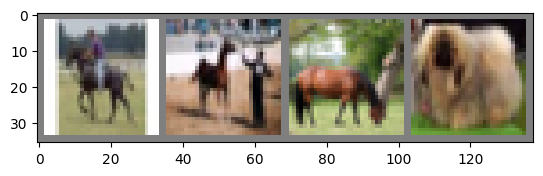

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

This is the model we'll train. If it looks familiar, that's because it's a variant of LeNet - discussed earlier in this video - adapted for 3-color images.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

The last ingredients we need are a loss function and an optimizer:

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

The loss function, as discussed earlier in this video, is a measure of how far from our ideal output the model's prediction was. Cross-entropy loss is a typical loss function for classification models like ours.

The **optimizer** is what drives the learning. Here we have created an optimizer that implements *stochastic gradient descent,* one of the more straightforward optimization algorithms. Besides parameters of the algorithm, like the learning rate (`lr`) and momentum, we also pass in `net.parameters()`, which is a collection of all the learning weights in the model - which is what the optimizer adjusts.

Finally, all of this is assembled into the training loop. Go ahead and run this cell, as it will likely take a few minutes to execute:

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.204
[1,  4000] loss: 1.882
[1,  6000] loss: 1.671
[1,  8000] loss: 1.570
[1, 10000] loss: 1.510
[1, 12000] loss: 1.446
[2,  2000] loss: 1.385
[2,  4000] loss: 1.352
[2,  6000] loss: 1.316
[2,  8000] loss: 1.294
[2, 10000] loss: 1.280
[2, 12000] loss: 1.269
Finished Training


Here, we are doing only **2 training epochs** (line 1) - that is, two passes over the training dataset. Each pass has an inner loop that **iterates over the training data** (line 4), serving batches of transformed input images and their correct labels.

**Zeroing the gradients** (line 9) is an important step. Gradients are accumulated over a batch; if we do not reset them for every batch, they will keep accumulating, which will provide incorrect gradient values, making learning impossible.

In line 12, we **ask the model for its predictions** on this batch. In the following line (13), we compute the loss - the difference between `outputs` (the model prediction) and `labels` (the correct output).

In line 14, we do the `backward()` pass, and calculate the gradients that will direct the learning.

In line 15, the optimizer performs one learning step - it uses the gradients from the `backward()` call to nudge the learning weights in the direction it thinks will reduce the loss.

The remainder of the loop does some light reporting on the epoch number, how many training instances have been completed, and what the collected loss is over the training loop.

**When you run the cell above,** you should see something like this:

```
[1,  2000] loss: 2.235
[1,  4000] loss: 1.940
[1,  6000] loss: 1.713
[1,  8000] loss: 1.573
[1, 10000] loss: 1.507
[1, 12000] loss: 1.442
[2,  2000] loss: 1.378
[2,  4000] loss: 1.364
[2,  6000] loss: 1.349
[2,  8000] loss: 1.319
[2, 10000] loss: 1.284
[2, 12000] loss: 1.267
Finished Training
```

Note that the loss is monotonically descending, indicating that our model is continuing to improve its performance on the training dataset.

As a final step, we should check that the model is actually doing *general* learning, and not simply "memorizing" the dataset. This is called **overfitting,** and usually indicates that the dataset is too small (not enough examples for general learning), or that the model has more learning parameters than it needs to correctly model the dataset.

This is the reason datasets are split into training and test subsets - to test the generality of the model, we ask it to make predictions on data it hasn't trained on:

In [8]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


If you followed along, you should see that the model is roughly 50% accurate at this point. That's not exactly state-of-the-art, but it's far better than the 10% accuracy we'd expect from a random output. This demonstrates that some general learning did happen in the model.